In [2]:
# -*- coding: utf-8 -*-
import os
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import csv

In [3]:
# ===== Configuración general =====
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ventana fija por hora (48h)
WINDOW_HOURS = 48
L_MAX = WINDOW_HOURS  # pasos temporales
TS_CHANNELS = 2       # HR + RR/MAP (o HR + Lactato)
D_MODEL = 128
N_HEADS = 4
N_LAYERS = 2
DROPOUT = 0.2
LR = 2e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 20
GRAD_CLIP = 1.0
BATCH_TRAIN = 64
BATCH_VAL = 128
BATCH_TEST = 128

# Diseño de pipeline

In [10]:
import os
import pandas as pd
import numpy as np

DATA_DIR = "/home/gmartinez/Tesis/Datasets/MIMIC-III"

admissions = pd.read_csv(os.path.join(DATA_DIR, "ADMISSIONS.csv"))
patients   = pd.read_csv(os.path.join(DATA_DIR, "PATIENTS.csv"))
labevents  = pd.read_csv(os.path.join(DATA_DIR, "LABEVENTS.csv"))
chartevents = pd.read_csv(os.path.join(DATA_DIR, "CHARTEVENTS.csv"))


In [11]:
for df, cols in [
    (admissions, ["ADMITTIME", "DISCHTIME", "DEATHTIME"]),
    (patients, ["DOB", "DOD"])
]:
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c])

# Mortalidad hospitalaria
admissions["MORTALITY"] = admissions["DEATHTIME"].notna().astype(int)

In [13]:
# Merge paciente-admisión
adm_pat = admissions.merge(patients, on="SUBJECT_ID", how="left")

In [16]:
print(adm_pat["DOB"].dt.year.value_counts().sort_index().head())
# Verás años como 1600-1700 para pacientes >89

DOB
1800    16
1801    36
1802    38
1803    26
1804    36
Name: count, dtype: int64


In [24]:
adm_pat["ADMITTIME"] = pd.to_datetime(adm_pat["ADMITTIME"], errors="coerce")
adm_pat["DOB"] = pd.to_datetime(adm_pat["DOB"], errors="coerce")

# Extraer años de forma segura
admit_year = adm_pat["ADMITTIME"].dt.year
dob_year = adm_pat["DOB"].dt.year

# Inicializar con 91.4 (asumir >89 por defecto)
adm_pat["AGE"] = 91.4

# Máscara para fechas válidas (DOB > 1900)
valid_mask = (
    adm_pat["ADMITTIME"].notna() & 
    adm_pat["DOB"].notna() & 
    (dob_year > 1900)
)

# Calcular edad aproximada con años (evita timedelta)
adm_pat.loc[valid_mask, "AGE"] = (
    admit_year[valid_mask] - dob_year[valid_mask]
)

# Refinamiento opcional con meses/días (solo si no da overflow)
try:
    delta_days = (
        adm_pat.loc[valid_mask, "ADMITTIME"] - 
        adm_pat.loc[valid_mask, "DOB"]
    ).dt.days
    adm_pat.loc[valid_mask, "AGE"] = delta_days / 365.25
except (OverflowError, AttributeError):
    pass  # Mantener la edad aproximada por años

# Cap a 89
adm_pat.loc[adm_pat["AGE"] > 89, "AGE"] = 89

In [25]:
# Número de ingresos previos del mismo paciente
adm_pat = adm_pat.sort_values(["SUBJECT_ID", "ADMITTIME"])
adm_pat["NUM_PREV_ADM"] = (
    adm_pat.groupby("SUBJECT_ID").cumcount()
)  # 0 = primer ingreso

context_cols = [
    "HADM_ID",
    "SUBJECT_ID",
    "MORTALITY",
    "AGE",
    "GENDER",
    "INSURANCE",
    "ADMISSION_TYPE",
    "ADMISSION_LOCATION",
    "ETHNICITY",
    "NUM_PREV_ADM",
    "ADMITTIME",
    "DISCHTIME",
]

cohort = adm_pat[context_cols].copy()

In [28]:
# Especificar ventana de tiempo
from datetime import timedelta

WINDOW_DAYS = 7
WINDOW_HOURS = WINDOW_DAYS * 24


In [29]:
hadm_to_admit = cohort.set_index("HADM_ID")["ADMITTIME"].to_dict()

In [30]:
# Columnas mínimas necesarias
lab_cols = ["HADM_ID", "ITEMID", "CHARTTIME", "VALUENUM"]
labevents = labevents[lab_cols].copy()
labevents["CHARTTIME"] = pd.to_datetime(labevents["CHARTTIME"])

# Filtrar a admisiones de la cohorte
hadm_ids = set(cohort["HADM_ID"])
labevents = labevents[labevents["HADM_ID"].isin(hadm_ids)]

# Tiempo relativo
def compute_rel_hours(row):
    admit = hadm_to_admit.get(row["HADM_ID"], None)
    if admit is None:
        return np.nan
    return (row["CHARTTIME"] - admit).total_seconds() / 3600.0

labevents["REL_HOURS"] = labevents.apply(compute_rel_hours, axis=1)
labevents = labevents[
    (labevents["REL_HOURS"] >= 0) &
    (labevents["REL_HOURS"] <= WINDOW_HOURS)
]

# Conteo de admisiones por ITEMID
lab_item_coverage = (
    labevents.dropna(subset=["VALUENUM"])
             .groupby("ITEMID")["HADM_ID"]
             .nunique()
             .sort_values(ascending=False)
)

In [32]:
d_labitems = pd.read_csv(os.path.join(DATA_DIR, "D_LABITEMS.csv"))
lab_stats = (
    lab_item_coverage
    .reset_index()
    .merge(d_labitems[["ITEMID", "LABEL"]], on="ITEMID", how="left")
    .sort_values("HADM_ID", ascending=False)
)

print(lab_stats.head(20))

    ITEMID  HADM_ID              LABEL
0    51221    55465         Hematocrit
1    51265    55248     Platelet Count
2    51301    55239  White Blood Cells
3    51222    55191         Hemoglobin
4    51249    55183               MCHC
6    51250    55176                MCV
5    51248    55176                MCH
7    51279    55176    Red Blood Cells
8    51277    55165                RDW
9    50971    52323          Potassium
10   50983    52299             Sodium
11   50902    52285           Chloride
12   50882    52255        Bicarbonate
13   50868    52236          Anion Gap
14   50912    50152         Creatinine
15   51006    50148      Urea Nitrogen
16   50931    49790            Glucose
17   50960    49323          Magnesium
18   50893    47760     Calcium, Total
19   50970    47696          Phosphate


In [33]:
# Intentar priorizar glucosa
glucose_candidate = lab_stats[lab_stats["LABEL"].str.contains("GLUCOSE", case=False, na=False)]
if len(glucose_candidate) > 0:
    LAB_ITEMID = int(glucose_candidate.iloc[0]["ITEMID"])
else:
    LAB_ITEMID = int(lab_stats.iloc[0]["ITEMID"])

print("Selected LAB ITEMID:", LAB_ITEMID)

Selected LAB ITEMID: 50931


In [35]:
chart_cols = ["HADM_ID", "ITEMID", "CHARTTIME", "VALUENUM"]
chartevents = chartevents[chart_cols].copy()
chartevents["CHARTTIME"] = pd.to_datetime(chartevents["CHARTTIME"])

chartevents = chartevents[chartevents["HADM_ID"].isin(hadm_ids)]

def compute_rel_hours_chart(row):
    admit = hadm_to_admit.get(row["HADM_ID"], None)
    if admit is None:
        return np.nan
    return (row["CHARTTIME"] - admit).total_seconds() / 3600.0

chartevents["REL_HOURS"] = chartevents.apply(compute_rel_hours_chart, axis=1)
chartevents = chartevents[
    (chartevents["REL_HOURS"] >= 0) &
    (chartevents["REL_HOURS"] <= WINDOW_HOURS)
]

chart_item_coverage = (
    chartevents.dropna(subset=["VALUENUM"])
               .groupby("ITEMID")["HADM_ID"]
               .nunique()
               .sort_values(ascending=False)
)

d_items = pd.read_csv(os.path.join(DATA_DIR, "D_LABITEMS.csv"))
chart_stats = (
    chart_item_coverage
    .reset_index()
    .merge(d_items[["ITEMID", "LABEL"]], on="ITEMID", how="left")
    .sort_values("HADM_ID", ascending=False)
)

print(chart_stats.head(30))

      ITEMID  HADM_ID LABEL
0   220602.0    15256   NaN
1   220615.0    15254   NaN
2   225624.0    15253   NaN
3   227443.0    15252   NaN
4   220545.0    15232   NaN
5   220645.0    15229   NaN
6   227442.0    15224   NaN
7   227457.0    15195   NaN
8   227073.0    15194   NaN
9   220546.0    15193   NaN
10  220228.0    15191   NaN
11  220621.0    15169   NaN
12  220635.0    14814   NaN
13  225677.0    14289   NaN
14  225625.0    14285   NaN
15  220045.0    13104   NaN
16  220210.0    13100   NaN
17  220277.0    13094   NaN
18  220047.0    13058   NaN
20  220046.0    13055   NaN
19  223770.0    13055   NaN
21  223769.0    13053   NaN
22  224161.0    13048   NaN
23  224162.0    13048   NaN
24  227467.0    13039   NaN
25  227465.0    13038   NaN
26  227466.0    12951   NaN
27  226253.0    12946   NaN
28  223761.0    12896   NaN
29  220179.0    12866   NaN


In [36]:
hr_candidate = chart_stats[chart_stats["LABEL"].str.contains("Heart Rate", case=False, na=False)]
spo2_candidate = chart_stats[chart_stats["LABEL"].str.contains("O2 Saturation", case=False, na=False)]

if len(hr_candidate) > 0:
    VITAL_ITEMID = int(hr_candidate.iloc[0]["ITEMID"])
elif len(spo2_candidate) > 0:
    VITAL_ITEMID = int(spo2_candidate.iloc[0]["ITEMID"])
else:
    VITAL_ITEMID = int(chart_stats.iloc[0]["ITEMID"])

print("Selected VITAL ITEMID:", VITAL_ITEMID)

Selected VITAL ITEMID: 220602


In [37]:
lab_ts = labevents[labevents["ITEMID"] == LAB_ITEMID].copy()
vital_ts = chartevents[chartevents["ITEMID"] == VITAL_ITEMID].copy()

# Asegurar orden por tiempo
lab_ts = lab_ts.sort_values(["HADM_ID", "REL_HOURS"])
vital_ts = vital_ts.sort_values(["HADM_ID", "REL_HOURS"])

In [38]:
from collections import defaultdict

def build_series_per_hadm(df, value_col="VALUENUM"):
    """
    df debe tener columnas: HADM_ID, REL_HOURS, VALUENUM
    Devuelve dict: hadm_id -> (t, x, m)
    """
    series = {}
    for hadm_id, grp in df.groupby("HADM_ID"):
        grp = grp.dropna(subset=[value_col, "REL_HOURS"])
        if grp.empty:
            continue
        t = grp["REL_HOURS"].values.astype(float)
        x = grp[value_col].values.astype(float)
        m = np.ones_like(x, dtype=int)
        series[hadm_id] = (t, x, m)
    return series

lab_series = build_series_per_hadm(lab_ts)
vital_series = build_series_per_hadm(vital_ts)

In [39]:
MAX_SAMPLES = 20000  # parámetro que puedes bajar

# Quedarnos solo con HADM_ID que tienen al menos alguna serie
valid_hadm_ids = set(lab_series.keys()) & set(vital_series.keys())
cohort_sub = cohort[cohort["HADM_ID"].isin(valid_hadm_ids)].copy()

# Barajar y cortar
cohort_sub = cohort_sub.sample(frac=1, random_state=42).head(MAX_SAMPLES)

In [40]:
context_cat_cols = ["GENDER", "INSURANCE", "ADMISSION_TYPE",
                    "ADMISSION_LOCATION", "ETHNICITY"]
context_num_cols = ["AGE", "NUM_PREV_ADM"]

# One-hot para categóricas
context_cat_dummies = pd.get_dummies(
    cohort_sub[context_cat_cols],
    dummy_na=True,
    prefix=context_cat_cols
)

context_num = cohort_sub[context_num_cols].fillna(cohort_sub[context_num_cols].mean())

context_matrix = np.hstack([context_num.values, context_cat_dummies.values])
context_feature_names = (
    context_num_cols + list(context_cat_dummies.columns)
)

In [41]:
examples = []

for idx, row in cohort_sub.iterrows():
    hadm_id = row["HADM_ID"]
    if (hadm_id not in lab_series) or (hadm_id not in vital_series):
        continue

    t_lab, x_lab, m_lab = lab_series[hadm_id]
    t_vital, x_vital, m_vital = vital_series[hadm_id]

    # Requerir mínimo de puntos en cada serie
    if len(t_lab) < 3 or len(t_vital) < 3:
        continue

    y = int(row["MORTALITY"])

    context_vec = np.hstack([
        context_num.loc[idx].values,
        context_cat_dummies.loc[idx].values
    ])

    examples.append({
        "hadm_id": hadm_id,
        "subject_id": row["SUBJECT_ID"],
        "label": y,
        "context": context_vec.astype(float),
        "t_lab": t_lab,
        "x_lab": x_lab,
        "m_lab": m_lab,
        "t_vital": t_vital,
        "x_vital": x_vital,
        "m_vital": m_vital,
    })

len(examples)

9240

In [43]:
import pickle

OUTPUT_PATH = "/home/gmartinez/Tesis/Datasets/MIMIC-III/mimic_mtan_glucose_hr_7d.pkl"

with open(OUTPUT_PATH, "wb") as f:
    pickle.dump({
        "examples": examples,
        "context_feature_names": context_feature_names,
        "lab_itemid": LAB_ITEMID,
        "vital_itemid": VITAL_ITEMID,
        "window_hours": WINDOW_HOURS,
    }, f)

In [44]:
import torch
from torch.utils.data import Dataset

class MTANMimicDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        ex = self.examples[idx]

        return {
            "label": torch.tensor(ex["label"], dtype=torch.float32),
            "context": torch.tensor(ex["context"], dtype=torch.float32),

            "t_lab": torch.tensor(ex["t_lab"], dtype=torch.float32),
            "x_lab": torch.tensor(ex["x_lab"], dtype=torch.float32),
            "m_lab": torch.tensor(ex["m_lab"], dtype=torch.float32),

            "t_vital": torch.tensor(ex["t_vital"], dtype=torch.float32),
            "x_vital": torch.tensor(ex["x_vital"], dtype=torch.float32),
            "m_vital": torch.tensor(ex["m_vital"], dtype=torch.float32),
        }

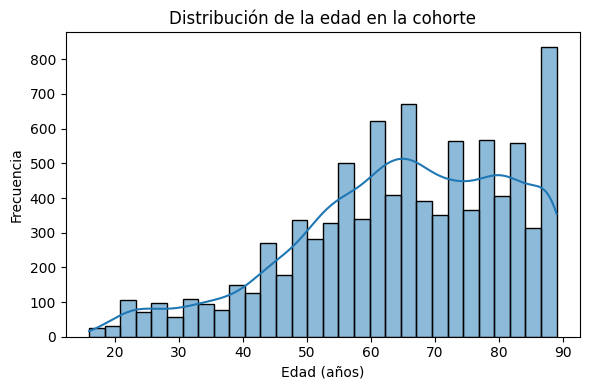

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

ages = [ex["context"][0] for ex in examples]  # suponiendo AGE es la primera

plt.figure(figsize=(6,4))
sns.histplot(ages, kde=True, bins=30)
plt.title("Distribución de la edad en la cohorte")
plt.xlabel("Edad (años)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

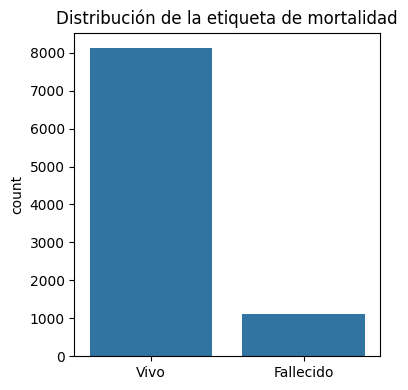

Tasa de mortalidad en la muestra: 0.12164502164502164


In [46]:
labels = np.array([ex["label"] for ex in examples])

plt.figure(figsize=(4,4))
sns.countplot(x=labels)
plt.xticks([0,1], ["Vivo", "Fallecido"])
plt.title("Distribución de la etiqueta de mortalidad")
plt.tight_layout()
plt.show()

mortality_rate = labels.mean()
print("Tasa de mortalidad en la muestra:", mortality_rate)

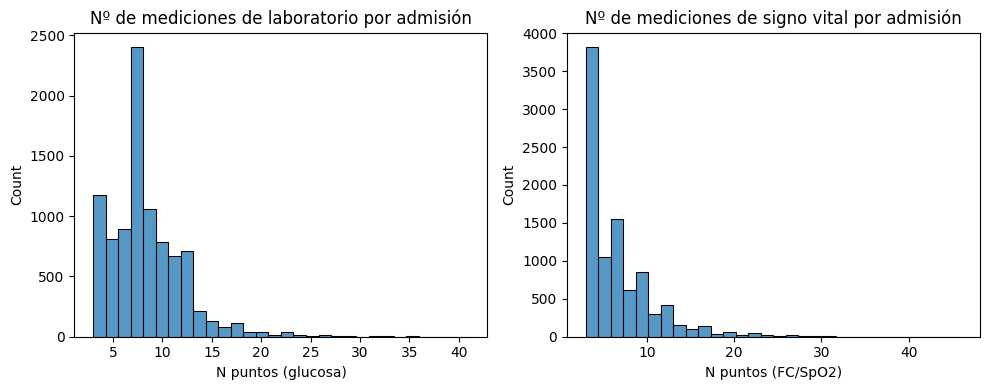

In [47]:
n_lab_points = np.array([len(ex["t_lab"]) for ex in examples])
n_vital_points = np.array([len(ex["t_vital"]) for ex in examples])

fig, axs = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(n_lab_points, bins=30, ax=axs[0])
axs[0].set_title("Nº de mediciones de laboratorio por admisión")
axs[0].set_xlabel("N puntos (glucosa)")
sns.histplot(n_vital_points, bins=30, ax=axs[1])
axs[1].set_title("Nº de mediciones de signo vital por admisión")
axs[1].set_xlabel("N puntos (FC/SpO2)")
plt.tight_layout()
plt.show()

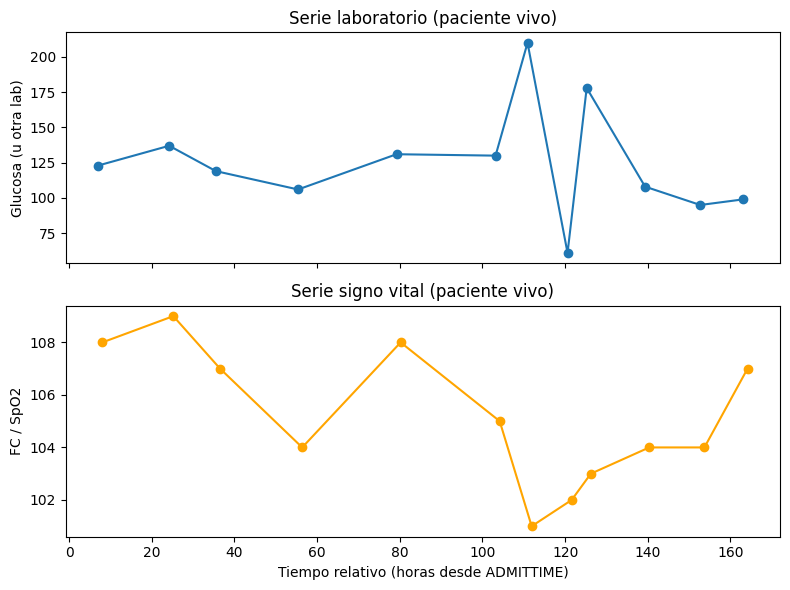

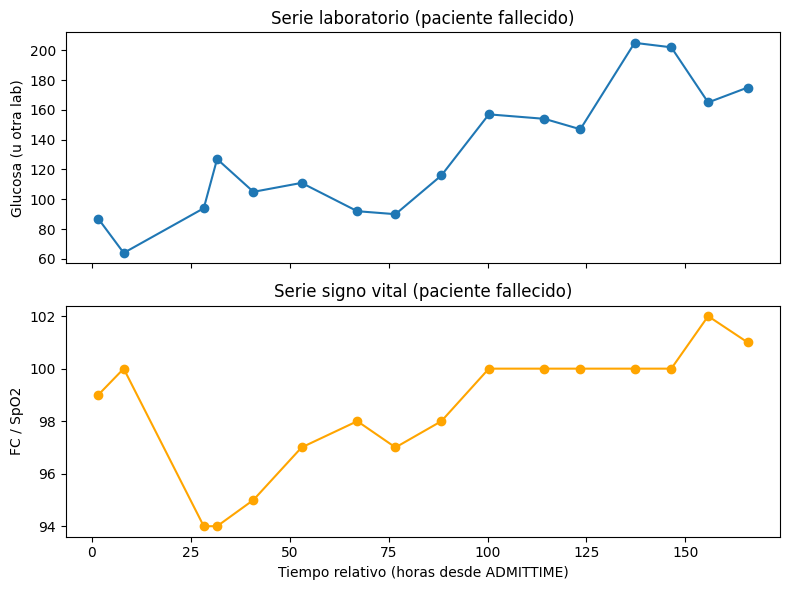

In [48]:
def plot_example(ex, title_suffix=""):
    fig, axs = plt.subplots(2, 1, figsize=(8,6), sharex=True)

    axs[0].plot(ex["t_lab"], ex["x_lab"], "o-")
    axs[0].set_ylabel("Glucosa (u otra lab)")
    axs[0].set_title(f"Serie laboratorio {title_suffix}")

    axs[1].plot(ex["t_vital"], ex["x_vital"], "o-", color="orange")
    axs[1].set_ylabel("FC / SpO2")
    axs[1].set_xlabel("Tiempo relativo (horas desde ADMITTIME)")
    axs[1].set_title(f"Serie signo vital {title_suffix}")

    plt.tight_layout()
    plt.show()

# Ejemplo: uno vivo y uno fallecido
alive_idx = next(i for i,e in enumerate(examples) if e["label"] == 0)
dead_idx  = next(i for i,e in enumerate(examples) if e["label"] == 1)

plot_example(examples[alive_idx], title_suffix="(paciente vivo)")
plot_example(examples[dead_idx], title_suffix="(paciente fallecido)")

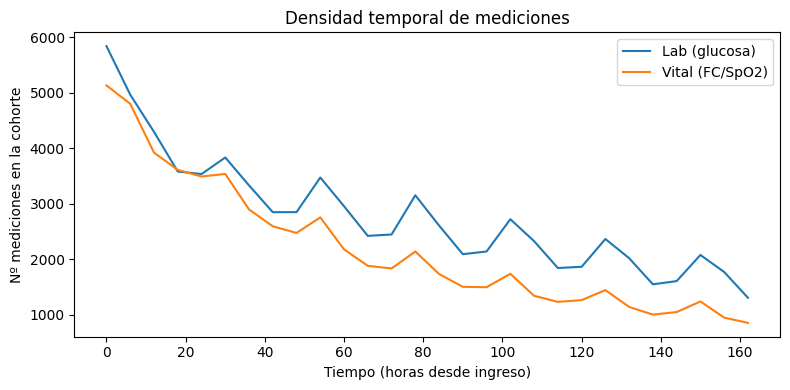

In [49]:
# Binning de tiempos (por ejemplo, en bloques de 6 horas)
bin_width = 6
max_time = WINDOW_HOURS
bins = np.arange(0, max_time + bin_width, bin_width)

lab_hist = np.zeros(len(bins)-1)
vital_hist = np.zeros(len(bins)-1)

for ex in examples:
    lab_hist += np.histogram(ex["t_lab"], bins=bins)[0]
    vital_hist += np.histogram(ex["t_vital"], bins=bins)[0]

plt.figure(figsize=(8,4))
plt.plot(bins[:-1], lab_hist, label="Lab (glucosa)")
plt.plot(bins[:-1], vital_hist, label="Vital (FC/SpO2)")
plt.xlabel("Tiempo (horas desde ingreso)")
plt.ylabel("Nº mediciones en la cohorte")
plt.title("Densidad temporal de mediciones")
plt.legend()
plt.tight_layout()
plt.show()